In [ ]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse

from sklearn.metrics import mean_squared_error
from prophet import Prophet

import warnings
warnings.filterwarnings('once')

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Initializing time series

In [3]:
# Correct the file path to the actual location of the CSV file
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv', sep=';')

# Convert HourDK to datetime
df['HourDK'] = pd.to_datetime(df['HourDK'])

# Convert ConsumptionkWh to numeric
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)

train_start = "2021-01-01"
train_end = "2023-11-30"
test_start = "2023-12-01"
test_end = "2024-11-10"

df.index = df['HourDK']

df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)
data_train = df[(df.index >= train_start) & (df.index <= train_end)]
data_test = df[(df.index >= test_start) & (df.index <= test_end)]

print(f"Training Set: {data_train.shape[0]} rows")
print(f"Test Set: {data_test.shape[0]} rows")

df = df['ConsumptionkWh']
print(df)
# print(data_train)
# print(data_test)

Training Set: 25512 rows
Test Set: 8281 rows
HourDK
2021-01-01 01:00:00    35086.772
2021-01-01 02:00:00    31777.762
2021-01-01 03:00:00    28423.659
2021-01-01 04:00:00    25675.926
2021-01-01 05:00:00    24283.909
                         ...    
2024-11-10 19:00:00    48584.696
2024-11-10 20:00:00    44105.371
2024-11-10 21:00:00    41492.172
2024-11-10 22:00:00    37148.073
2024-11-10 23:00:00    33307.696
Name: ConsumptionkWh, Length: 33839, dtype: float64


Plotting the time series

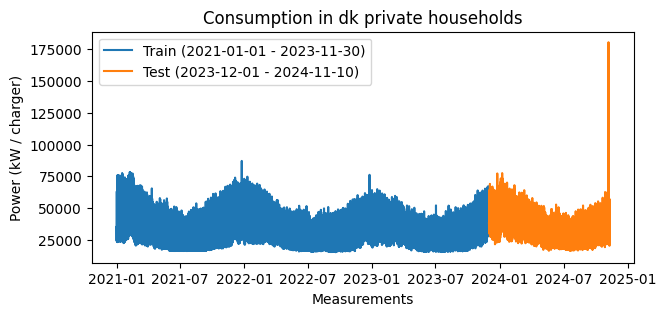

In [3]:
plt.figure(figsize=(7, 3))
plt.plot(data_train.index, data_train['ConsumptionkWh'], label=f'Train ({train_start} - {train_end})')
plt.plot(data_test.index, data_test['ConsumptionkWh'], label=f'Test ({test_start} - {test_end})')
plt.title('Consumption in dk private households')
plt.xlabel('Measurements')
plt.ylabel('Power (kW / charger)')
plt.legend()
plt.show()

Test stationality in time series and if differentiation is required

C:\Users\sebas\AppData\Local\Temp\ipykernel_19000\1158987354.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data)


ADF Statistic: -9.80527903271043, p-value: 5.848531486170014e-17
KPSS Statistic: 2.04428348664048, p-value: 0.01
stationary = True, differentiation needed = True


C:\Users\sebas\AppData\Local\Temp\ipykernel_19000\1158987354.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data)


ADF Statistic: -36.83226495972392, p-value: 0.0
KPSS Statistic: 0.0028476578951469535, p-value: 0.1
stationary = True, differentiation needed = False


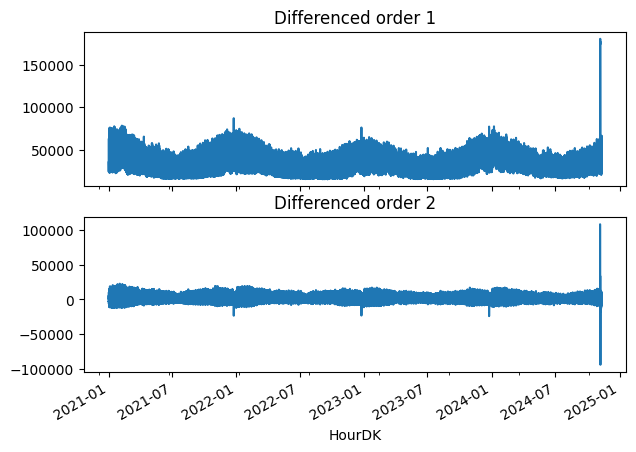

In [4]:
def test_stationality_adf_kpss(data, alpha=0.05):
    adfuller_result = adfuller(data)
    kpss_result = kpss(data)
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
    print(f'stationary = {adfuller_result[1] < alpha}, differentiation needed = {kpss_result[1] < alpha}')
    
df_diff_1 = df.diff().dropna()

# warnings.filterwarnings("ignore")
test_stationality_adf_kpss(df)
test_stationality_adf_kpss(df_diff_1)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
df.plot(ax=axs[0], title='Differenced order 1')
df_diff_1.plot(ax=axs[1], title='Differenced order 2');
# warnings.filterwarnings("default")
# result = (d=1)

Autocorrelation Analysis (for ARIMA and variants)

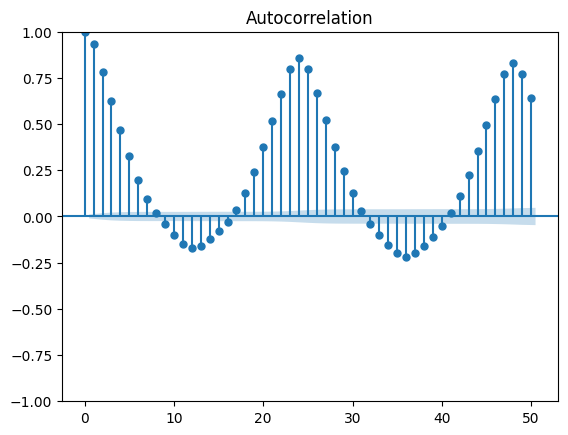

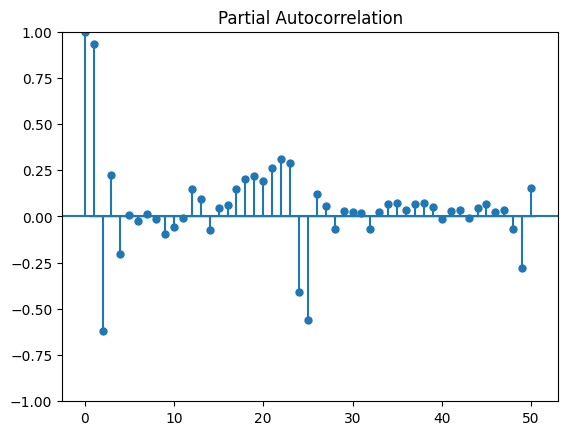

In [5]:
#find q
plot_acf(df, lags=50, alpha=0.05);
#on autocorrelation graph: a sinus pattern is present, suggesting seasonality
#order of MA term: take term q equal to the number of lags crossing the significance limit
#q=47

#find p
plot_pacf(df, lags=50, alpha=0.05);
#order of AR term: take term p equal to the number of lags crossing the significance limit
#p=51

Seasonal Decomposition

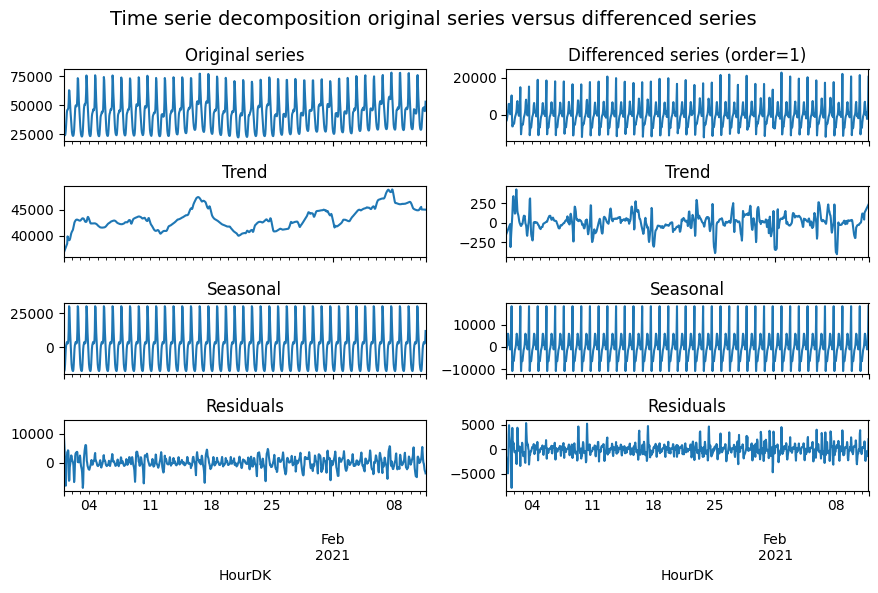

In [6]:
res_decompose = seasonal_decompose(df.head(1000), model='additive', extrapolate_trend='freq', period=24)
res_decompose_diff_1 = seasonal_decompose(df_diff_1.head(1000), model='additive', extrapolate_trend='freq', period=24)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])  
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_decompose_diff_1.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_decompose_diff_1.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_decompose_diff_1.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_decompose_diff_1.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout()

Models and predictions

In [3]:
model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)

predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels(1,1,1)'
# display(predictions_statsmodels.head(4))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [4]:
model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)

predictions_statsmodels2 = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels2.name = 'predictions_statsmodels(1,1,4)'

KeyboardInterrupt: 

In [9]:
stlf = STLForecast(data_train, SARIMAX, model_kwargs=dict(order=(1, 1, 1), seasonal_order = (1, 1, 1, 12)), period=24)
model_res = stlf.fit()
predictions_stlf = model_res.forecast(len(data_test))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
model = ThetaModel(data_train, period=24, method="additive")
model_res = model.fit()
predictions_theta = model_res.forecast(len(data_test))
predictions_theta.index = data_test.index

model2 = ThetaModel(data_train, period=24, method="multiplicative")
model2_res = model2.fit()
predictions_theta2 = model2_res.forecast(len(data_test))
predictions_theta2.index = data_test.index

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\forecasting\theta.py:44: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  return DeterministicTerm._extend_index(index, steps)


In [11]:
model = DynamicFactorMQ(endog=data_train)
model_res = model.fit()
predictions_dynamicFactorMQ = model_res.forecast(len(data_test))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Plot of forecasts

In [12]:
predictions_statsmodels.index = data_test.index
predictions_statsmodels2.index = data_test.index
predictions_stlf.index = data_test.index
predictions_theta.index = data_test.index
predictions_theta2.index = data_test.index
predictions_dynamicFactorMQ.index = data_test.index

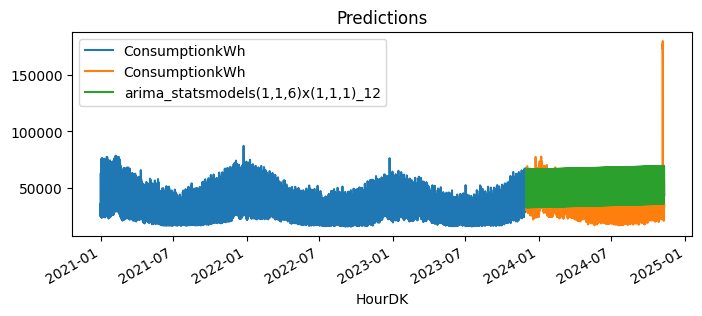

In [13]:
fig, ax = plt.subplots(figsize=(8, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_statsmodels.plot(ax=ax, label='arima_statsmodels(1,1,6)x(1,1,1)_12')
# predictions_statsmodels2.plot(ax=ax, label='arima_statsmodels(1,1,4)x(1,1,1)_12')
# predictions_dynamicFactorMQ.plot(ax=ax, label='dynamicFactorMQ')
# predictions_stlf.plot(ax=ax, label='stlf')
# predictions_theta.plot(ax=ax, label='theta')
# predictions_theta2.plot(ax=ax, label='theta2')
ax.set_title('Predictions')
ax.legend()

Evaluate algorithm performance

In [14]:
def evaluate(prediction, name):
    print(f"-- {name} --")
    print(f"mse: {mean_squared_error(data_test, prediction)}") #penalizes larger errors more
    print(f"rmse: {mean_squared_error(data_test, prediction, squared=False)}")

evaluate(predictions_statsmodels, "statsmodels(1,1,6)x(1,1,1)_12")
evaluate(predictions_statsmodels2, "statsmodels(1,1,4)x(1,1,1)_12")
evaluate(predictions_stlf, "stlf")
evaluate(predictions_theta, "theta")
evaluate(predictions_theta2, "theta2")
evaluate(predictions_dynamicFactorMQ, "dynamicFactorMQ")


-- statsmodels(1,1,6)x(1,1,1)_12 --
mse: 212123132.9092469
rmse: 14564.447566222581
-- statsmodels(1,1,4)x(1,1,1)_12 --
mse: 323930572.56165826
rmse: 17998.071356722037
-- stlf --
mse: 239932194.18298104
rmse: 15489.744806903083
-- theta --
mse: 261183750.12175646
rmse: 16161.180344323755
-- theta2 --
mse: 476970457.70481414
rmse: 21839.653332981597
-- dynamicFactorMQ --
mse: 141899885.82457784
rmse: 11912.173849662278


Automating finding best parameters

In [6]:
def optimize_SARIMAX(endog):
  results = []
  p = d = q = range(0, 3)
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(endog, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False).fit(maxiter=200, disp=0) #disp=0 to reduce output verbosity
        except:
            continue

        aic = model.aic
        rmse = mean_squared_error(endog, model.fittedvalues, squared=False)
        results.append([f"{param}x{seasonal_param}", aic, rmse])

  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic', 'rmse']
  result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)

  return result_table

optimize_SARIMAX(data_train)

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro